# Import Library

In [29]:
# Ignore  the warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

# data visualisation and manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns

#configure
# sets matplotlib to inline and displays graphs below the corressponding cell.
%matplotlib inline  
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)

#import the necessary modelling algos.
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier

#model selection
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,roc_auc_score

#preprocess.
from sklearn.preprocessing import MinMaxScaler,StandardScaler,LabelEncoder,OneHotEncoder,RobustScaler

In [30]:
df=pd.read_csv('df_final.csv')

In [31]:
df.head()

,label,ZCR,SC,RMSE,Chroma,Spectogram
0,0,0.000000,0.000000,0.000000,0.000000,0.000000
1,0,0.056641,1909.595014,0.068671,1.000000,1.258348
2,0,0.063477,2895.274934,0.090183,1.000000,0.586347
3,0,0.063477,1638.177354,0.075589,0.394161,2.289205
4,0,0.041016,1481.953495,0.091812,0.171806,0.257900


In [32]:
df['label'].value_counts()

2    465
0    406
1    393
Name: label, dtype: int64

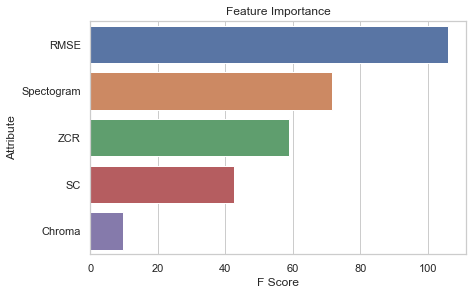

In [33]:
from sklearn.feature_selection import SelectKBest, f_classif

def select_kbest_clf(df, target, k=5):
    """
    Selecting K-Best features for classification
    - df: A pandas dataFrame with the training data
    - target: target variable name in DataFrame
    - k: desired number of features from the data
    
    returns feature_scores: scores for each feature 
    """
    feat_selector = SelectKBest(f_classif, k=k)
    _= feat_selector.fit(df.drop(target, axis=1), df[target])
    
    feat_scores = pd.DataFrame()
    feat_scores["F Score"] = feat_selector.scores_
    feat_scores["P Value"] = feat_selector.pvalues_
    feat_scores["Support"] = feat_selector.get_support()
    feat_scores["Attribute"] = df.drop(target, axis=1).columns
    
    return feat_scores
    
k=select_kbest_clf(df, 'label', k=5).sort_values(['F Score'],ascending=False)
plt.figure()
k1=sns.barplot(x=k['F Score'],y=k['Attribute'])
k1.set_title('Feature Importance')
plt.show()

# Oversampling

In [34]:
df_class_0 = df[df['label']==0]
df_class_1 = df[df['label']==1]
df_class_2 = df[df['label']==2]
df_class_0.shape, df_class_1.shape, df_class_2.shape

((406, 6), (393, 6), (465, 6))

In [35]:
df_class_0_over = df_class_0.sample(1500, replace=True)
df_class_1_over = df_class_1.sample(1500, replace=True)
df_class_2_over = df_class_2.sample(1500, replace=True)

In [36]:
df_final = pd.concat([df_class_0_over, df_class_1_over, df_class_2_over], axis=0)
df_final['label'].value_counts()

0    1500
1    1500
2    1500
Name: label, dtype: int64

# Scaling

In [37]:
scaler=RobustScaler()
scaled_df=scaler.fit_transform(df_final.drop('label',axis=1))
X=scaled_df
Y=df_final['label']

# Spliting

In [38]:
x_train,x_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.2,random_state=42,stratify=Y)

# ML Modeling

In [39]:
models=[LogisticRegression(),LinearSVC(),SVC(kernel='rbf'),KNeighborsClassifier(),RandomForestClassifier(),
        DecisionTreeClassifier(),GradientBoostingClassifier(),GaussianNB(), XGBClassifier()]
model_names=['LogisticRegression','LinearSVM','rbfSVM','KNearestNeighbors','RandomForestClassifier','DecisionTree',
             'GradientBoostingClassifier','GaussianNB', 'XGBClassifier']

acc=[]
d={}

for model in range(len(models)):
    clf=models[model]
    clf.fit(x_train,Y_train)
    pred=clf.predict(x_test)
    acc.append(accuracy_score(pred,Y_test))
     
d={'Modelling Algo':model_names,'Accuracy':acc}

[08:57:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [42]:
acc_frame=pd.DataFrame(d)
acc_frame

,Modelling Algo,Accuracy
0,LogisticRegression,0.570000
1,LinearSVM,0.551111
2,rbfSVM,0.604444
3,KNearestNeighbors,0.798889
4,RandomForestClassifier,0.978889
5,DecisionTree,0.974444
6,GradientBoostingClassifier,0.784444
7,GaussianNB,0.497778
8,XGBClassifier,0.977778


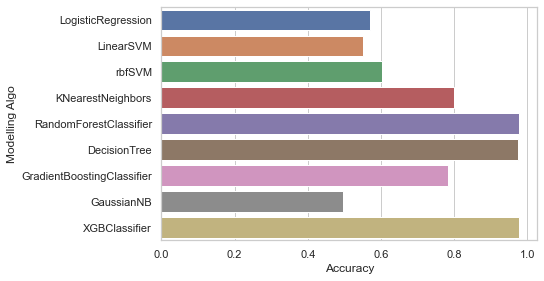

In [43]:
sns.barplot(y='Modelling Algo',x='Accuracy',data=acc_frame)
plt.show()